# Classification on diabetes dataset

We import all the necessary packages into the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
import seaborn as sns

We first load the training dataset *diabetes_samples.csv* and test dataset *diabetes_test.csv* into pandas data frames. 

In [298]:
diabetes_train = pd.read_csv("diabetes_samples.csv")
diabetes_test = pd.read_csv("diabetes_test.csv")

We print the first few rows of the dataset and view the summary statistics of the dataset to inspect the dataset.

In [299]:
diabetes_train.head()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,115,224,85,30,"7,5",36,69,205,"30,3",150,99,37,41,"0,9",No diabetes
1,318,194,95,36,"5,4",63,58,210,"43,9",140,100,44,53,"0,83",No diabetes
2,73,207,75,44,"4,7",30,72,180,"24,4",118,62,35,41,"0,85",No diabetes
3,69,144,81,28,"5,1",30,72,165,"22,4",118,78,31,38,"0,82",No diabetes
4,326,181,177,24,"7,5",64,71,225,"31,4",130,66,44,47,"0,94",Diabetes


In [300]:
diabetes_train.describe()

,patient_number,cholesterol,glucose,hdl_chol,age,height,weight,systolic_bp,diastolic_bp,waist,hip
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,199.695971,208.868132,108.864469,50.531136,47.622711,66.032967,177.424908,136.772894,82.553114,37.941392,43.102564
std,115.880545,45.051737,55.762363,17.041255,17.110598,3.867618,40.460071,22.621073,13.161257,5.744903,5.834459
min,1.000000,78.000000,52.000000,12.000000,19.000000,55.000000,99.000000,98.000000,50.000000,26.000000,32.000000
25%,96.000000,179.000000,81.000000,39.000000,34.000000,63.000000,151.000000,121.000000,74.000000,33.000000,39.000000
50%,198.000000,204.000000,90.000000,46.000000,45.000000,66.000000,174.000000,136.000000,82.000000,37.000000,42.000000
75%,306.000000,232.000000,108.000000,59.000000,61.000000,69.000000,200.000000,148.000000,90.000000,42.000000,46.000000
max,390.000000,404.000000,385.000000,120.000000,92.000000,76.000000,308.000000,250.000000,118.000000,53.000000,64.000000


We set the index of the dataframe as *patient_number*.

In [301]:
diabetes_train = diabetes_train.set_index(diabetes_train['patient_number']).drop(diabetes_train.columns[0], axis=1)

For the columns *chol_hdl_ratio*, *bmi* and *waist_hip_ratio*, we will replace the `,` sign with `.`.

In [302]:
for column_name in ['chol_hdl_ratio', 'bmi', 'waist_hip_ratio']: 
    diabetes_train[column_name] = diabetes_train[column_name].str.replace(',', '.').astype(float)

For the target variable *diabetes*, we will replace the category `No diabetes` with `0` and the category `Diabetes` with `1`.

In [303]:
diabetes_train['diabetes'] = pd.factorize(diabetes_train['diabetes'])[0]

The dataset does not have any missing values and now seems cleaned.

In [304]:
diabetes_train.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
patient_number,,,,,,,,,,,,,,
115,224,85,30,7.5,36,69,205,30.3,150,99,37,41,0.90,0
318,194,95,36,5.4,63,58,210,43.9,140,100,44,53,0.83,0
73,207,75,44,4.7,30,72,180,24.4,118,62,35,41,0.85,0
69,144,81,28,5.1,30,72,165,22.4,118,78,31,38,0.82,0
326,181,177,24,7.5,64,71,225,31.4,130,66,44,47,0.94,1


We will apply the same data transformations onto the test dataset.

In [305]:
diabetes_test = diabetes_test.set_index(diabetes_test['patient_number']).drop(diabetes_test.columns[0], axis=1)

for column_name in ['chol_hdl_ratio', 'bmi', 'waist_hip_ratio']: 
    diabetes_test[column_name] = diabetes_test[column_name].str.replace(',', '.').astype(float)
    
diabetes_test['diabetes'] = pd.factorize(diabetes_test['diabetes'])[0]

We now split the training dataset into predictor set `X_d_train` and target `y_d_train`. We will also split the test dataset into predictor set `X_d_test` and target `y_d_test`.

In [306]:
X_d_train = diabetes_train.iloc[:,:-1]
y_d_train = diabetes_train.iloc[:,-1]
X_d_test = diabetes_test.iloc[:,:-1]
y_d_test = diabetes_test.iloc[:,-1]

## 2.1 Random forest

`training_weights` assigns equal weights to each observation. <br>
`columns_dict` is a dictionary indicating whether the column index maps to a categorical feature or numerical. In this dataset, all the features are numerical so categorical=False for all columns.

In [307]:
training_weights = np.ones_like(y_d_train) / len(y_d_train)
columns_dict = {index: False for index in range(X_d_train.shape[1])}

The function `cross_entropy` computes cross entropy using the formula:
$$CE[\pi(R_{\alpha})]=\sum_{q=1}^{Q}{\pi_{q}(R_{\alpha})\log\pi_{q}(R_{\alpha})}$$
where $\pi_{q}(R_{\alpha})$ is the probability of being in given region $R_{\alpha}$ and belonging to a particular class $c_{q}$.

In [308]:
def cross_entropy(y, sample_weights):
    """ 
    Calculate the cross entropy for labels.
    Arguments:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        (float): the cross entropy for y.
    """

    # count different labels in y，and store in label_weights
    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}  
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    total_weight = sum(label_weights.values())
    CE = 0
    for label, weight in label_weights.items():
        CE -= (weight / total_weight) * np.log(weight / total_weight)

    return CE

The function`split_samples` splits the data samples based on a column index and a value.

In [309]:
def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
        1. equals value, in case `column` is categorical, or
        2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples 
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
    """ 

    if categorical:
        left_mask =(X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)
  
    X_left, X_right = X[left_mask, :], X[~left_mask, :]
    y_left, y_right = y[left_mask], y[~left_mask]
    w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

    return (X_left, X_right), (y_left, y_right), (w_left, w_right)

The function `cross_entropy_split_value` searches for the threshold that minimises the cross entropy.

In [310]:
def cross_entropy_split_value(X, y, sample_weights, column, categorical):
    """
    Calculate the cross entropy based on `column` with the split that minimizes the cross entropy.
    Arguments:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for calculating. 0 <= column < D
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        (float, float): the resulted cross entropy and the corresponding value used in splitting.
    """
  
    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    cross_entropy_val, threshold = np.inf, None
  
    # split the values of i-th feature and calculate the cost 
    for value in unique_vals:
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical)

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue
    
        p_left = sum(w_l)/(sum(w_l) + sum(w_r))
        p_right = 1 - p_left
        new_cost = p_left * cross_entropy(y_l, w_l) + p_right * cross_entropy(y_r, w_r)
        if new_cost < cross_entropy_val:
            cross_entropy_val, threshold = new_cost, value
    
    return cross_entropy_val, threshold

The function `cross_entropy_split_rf` implements feature bagging and then finds the best split column and split value which minimises the cross entropy.

In [311]:
def cross_entropy_split_rf(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Arguments:
        n_features: number of sampled features.
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimized cross entropy, the best feature index and value used in splitting.
    """
    # feature bagging
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_cross_entropy, split_column, split_val = np.inf, 0, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        cross_entropy, val = cross_entropy_split_value(X, y, sample_weights, column, categorical)     
        if cross_entropy < min_cross_entropy:
            min_cross_entropy, split_column, split_val = cross_entropy, column, val

    return min_cross_entropy, split_column, split_val

The function `majority_vote` returns a dictionary containing the probabilities of a label being 0 and 1.

In [312]:
def majority_vote(y, sample_weights):
    """
    Arguments:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        prob: a dictionary containing the probabilities of a label being 0 and 1
    """
    majority_label = {yi: 0 for yi in set(y)}

    for yi, wi in zip(y, sample_weights):
        majority_label[yi] += wi
    
    total_weight = sum(majority_label.values())
    if 1 in majority_label.keys():
        class1 = majority_label[1]
    else:
        class1 = 0
    prob1 = class1 / total_weight
    prob0 = 1 - prob1
    
    # EDIT
    prob = {0: prob0, 1: prob1}
    return prob

The function `build_tree_rf` builds the decision tree according to the data.

In [313]:
def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, max_depth, depth, min_samples_leaf=1):
    """Build the decision tree according to the data.
    Arguments:
        n_features: number of predictors taken into consideration randomly at each split.
        X: (np.array) training features, of shape (N, D).
        y: (np.array) vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        max_depth: maximum depth of trees.
        depth (int): current depth for this node.
        min_sample_leaf: minimum number of instances at a leaf.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
            1. 'feature_name': The column name of the split.
            2. 'feature_index': The column index of the split.
            3. 'value': The value used for the split.
            4. 'categorical': indicator for categorical/numerical variables.
            5. 'prob': For leaf nodes, this stores the probability of a label being 0 and 1. Otherwise, it is None.
            6. 'left': The left sub-tree with the same structure.
            7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'prob': majority_vote(y, sample_weights)}
  
    else:
        CE, split_index, split_val = cross_entropy_split_rf(n_features, X, y, sample_weights, columns_dict)
    
        # If CE is infinity, it means that samples are not seperable by the sampled features.
        if CE == np.inf:
            return {'prob': majority_vote(y, sample_weights)}
        categorical = columns_dict[split_index]
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical)
        return {
            'feature_name': feature_names[split_index],
            'feature_index': split_index,
            'value': split_val,
            'categorical': categorical,
            'prob': None,
            'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, feature_names, max_depth, depth + 1, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names, max_depth, depth + 1, min_samples_leaf) 
        }

The function `train_rf` builds the random forest model according to the training data.

In [314]:
def train_rf(B, n_features, max_depth, X, y, columns_dict, sample_weights=None):
    """
    Build the random forest model according to the training data.
    Args:
        B: number of decision trees.
        n_features: number of predictors taken into consideration randomly at each split.
        max_depth: maximum depth of trees.
        X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, columns_dict, feature_names, max_depth, depth=1)
        trees.append(tree)

    return trees

The function `classify` takes each single data point `x` as an argument and returns the dictionary containing the probabilities of the label being 0 and 1.

In [315]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        prob: a dictionary containing the probabilities of a label being 0 and 1
    """
    
    if tree['prob'] is not None: 
        return tree['prob']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

    else:
        if x[tree['feature_index']] < tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

The function `predict_rf` function aggregates the probabilities from all decision trees and returns the class based on the threshold provided.

In [316]:
def predict_rf(rf, X, B, roc_threshold):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, D).
        roc_threshold: threshold probability for a label to be classified as 1.
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    def aggregate(decisions):
        count = defaultdict(int)
        for decision in decisions:
            count[0] += decision[0]
            count[1] += decision[1]
        prob0 = count[0] / B
        prob1 = count[1] / B
        if prob1 >= roc_threshold:
            return 1
        else:
            return 0

    if len(X.shape) == 1:
        return aggregate([classify(tree, X) for tree in rf])
    else:
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

The function `rf_accuracy` computes accuracy using the formula:
$$\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives and FN is the number of false negatives.

In [317]:
# accuracy
def rf_accuracy(rf, X_test, y_test, B, roc_threshold):
    y_pred = predict_rf(rf, X_test, B, roc_threshold)
    return np.mean(y_pred==y_test)

In [318]:
def cross_val_split_pd(X, num_folds):
    N = X.shape[0]
    fold_size = N // num_folds
    index_perm = np.random.permutation(X.index)
    folds = []
    for k in range(num_folds):
        folds.append(index_perm[k*fold_size:(k+1)*fold_size])
    return folds

The function `cross_val_evaluate_rf` implements T-fold cross validation and returns the accuracy for the training dataset and validation set at each training/validation split.

In [319]:
def cross_val_evaluate_rf(X, y, num_folds, B, max_depth, sample_weights, roc_threshold):
    """
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        num_folds: number of folds for cross-validation
        B: number of decision trees
        max_depth: maximum depth of trees
        sample_weights:  weights for each samples, of shape (N,)
        roc_threshold: threshold probability for a label to be classified as 1
    Returns:
        train_scores: list of training scores for each training/validation split
        val_scores: list of validation scores for each training/validation split
    """
    folds = cross_val_split_pd(X, num_folds)
    # number of features for feature bagging is set to be square root of the number of predictors
    n_features = int(np.sqrt(X.shape[1]))

    train_scores = []
    val_scores = []
  
    for i in range(len(folds)):

        val_indices = folds[i]
        train_indices = list(set(set(X.index) - set(val_indices)))
        
        # define the training set
        X_train = X.loc[train_indices,:] 
        y_train = y[train_indices]
    
        # define the validation set
        X_val = X.loc[val_indices,:]  
        y_val = y[val_indices] 

        # train the model
        rf = train_rf(B, n_features, max_depth, X_train, y_train, columns_dict, sample_weights)

        # evaluate the scores of the training and validation set
        train_score = rf_accuracy(rf, X_train.to_numpy(), y_train.to_numpy(), B, roc_threshold)
        val_score = rf_accuracy(rf, X_val.to_numpy(), y_val.to_numpy(), B, roc_threshold)
        
        # store the training scores and validation scores
        train_scores.append(train_score)
        val_scores.append(val_score)

    return train_scores, val_scores

The function `grid_search_rf` loops through the list of B values and max_depth values pairwise to find the number of decision trees and maximum depth of decision trees which gives the highest average accuracy for the validation set.

In [320]:
def grid_search_rf(X, y, num_folds, hyperparameters, sample_weights, roc_threshold):
    """
    Performs grid search over hyperparameters.
    Arguments:
        X: data of size (n, d)
        y: true label vector of size (n, 1)
        num_folds: number of folds for cross-validation
        hyperparameters: a dictionary containing list of hyperparameters (B and max_depth)
        sample_weights:  weights for each samples, of shape (N,)
        roc_threshold: threshold probability for a label to be classified as 1
    Returns:
        best_B: B which gives the highest average accuracy for the validation set when paired with best_max_depth
        best_max_depth: max_depth which gives the highest average accuracy for the validation set when paired with best_B
        best_mean_val: highest average accuracy for the validation set
    """
    B_list = hyperparameters["B"]
    max_depth_list = hyperparameters["max_depth"]
    best_B = B_list[0]
    best_max_depth = max_depth_list[0]
    best_mean_val = 0
    mean_val_list = []
    for B in B_list:
        for max_depth in max_depth_list:
            # compute accuracy for each training/validation split
            train_scores, val_scores = cross_val_evaluate_rf(X, y, num_folds, B, max_depth, sample_weights, roc_threshold)
            
            # compute average accuracy
            mean_train = np.mean(train_scores)
            mean_val = np.mean(val_scores)
            # print("B = {}, max_depth = {}: mean training accuracy is {}, mean validation accuracy is {}".format(B, max_depth, mean_train, mean_val))
            mean_val_list.append(mean_val)
            
            # update best B, best max_depth and highest average accuracy for validation set
            if mean_val > best_mean_val:
                best_B = B
                best_max_depth = max_depth
                best_mean_val = mean_val
    return best_B, best_max_depth, best_mean_val, mean_val_list

We now employ a 4-fold cross validation to tune the the number of decision trees, B and the maximum depth of decision trees, max_depth.

In [321]:
hyperparameters = {"B": [40, 50, 60, 70, 80], "max_depth": [5, 6, 7, 8, 9]}
best_B, best_max_depth, best_mean_val, mean_val_list = grid_search_rf(X_d_train, y_d_train, 4, hyperparameters, training_weights, 0.5)

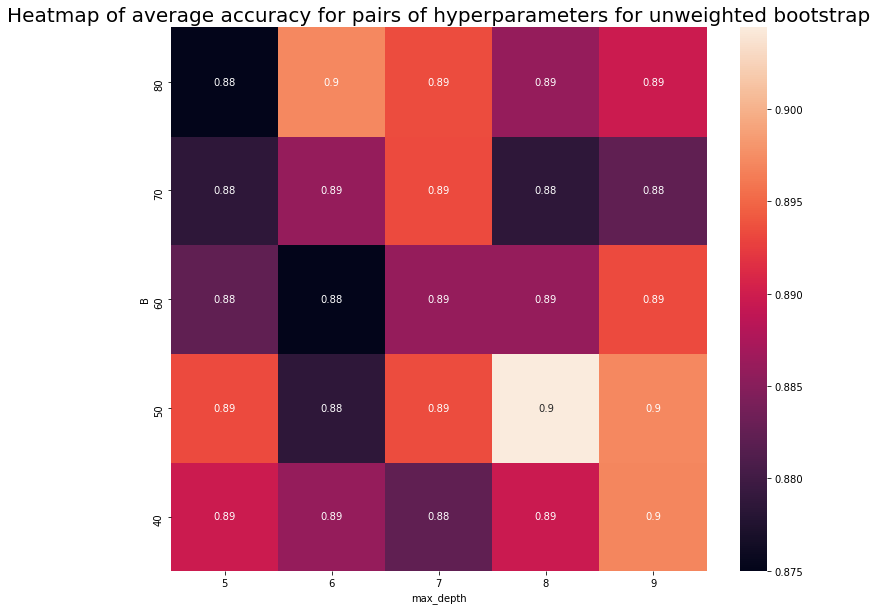

In [322]:
# Heatmap of average accuracy for pairs of hyperparameters for unweighted bootstrap
combination_list = [p for p in product(hyperparameters["B"], hyperparameters["max_depth"])]
df_h_uw = pd.DataFrame(combination_list, columns=["B","max_depth"])
df_h_uw["Average Accuracy"] = mean_val_list
df_h_uw = df_h_uw.pivot("B", "max_depth", "Average Accuracy")
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(df_h_uw, annot=True)
plt.title("Heatmap of average accuracy for pairs of hyperparameters for unweighted bootstrap", fontsize=20)
ax.invert_yaxis()

In [323]:
print("The optimal value of B is {} and optimal value of max_depth is {}".format(best_B, best_max_depth))

The optimal value of B is 50 and optimal value of max_depth is 8


We will now retrain the model on the entire training dataset using the optimal B and max_depth found above.

In [324]:
n_features = int(np.sqrt(X_d_train.shape[1]))
best_rf = train_rf(best_B, n_features, best_max_depth, X_d_train, y_d_train, columns_dict, training_weights)

The function `rf_scores` computes the the following quality measures:
1. $\text{precision}=\frac{TP}{TP + FP}$
2. $\text{F-score}=2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$
3. $\text{recall} = \frac{TP}{TP + FN}$
4. $\text{false positive rate} = \frac{FP}{TN + FP}$

In [325]:
# precision, F-score, recall, fpr
def rf_scores(rf, X_test, y_test, B, roc_threshold):
    y_pred = predict_rf(rf, X_test, B, roc_threshold)
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_test)):
        if y_pred[i] == y_test[i] == 1:
            TP +=1
        elif y_pred[i] == 1 and y_test[i] == 0:
            FP +=1
        elif y_pred[i] == 0 and y_test[i] == 1:
            FN += 1
        else:
            TN += 1
    recall = TP / (TP + FN)
    fpr = FP / (TN + FP) 
    if (TP + FP) == 0:
        precision = None
        F_score = None
    else:
        precision = TP / (TP + FP)
        F_score = 2 * precision * recall / (precision + recall)
    return precision, F_score, recall, fpr

In [326]:
# Compute accuracy, precision and F-score
acc_train = rf_accuracy(best_rf, X_d_train.to_numpy(), y_d_train.to_numpy(), best_B, 0.5)
acc_test = rf_accuracy(best_rf, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B, 0.5)
scores_train = rf_scores(best_rf, X_d_train.to_numpy(), y_d_train.to_numpy(), best_B, 0.5)
scores_test = rf_scores(best_rf, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B, 0.5)

In [327]:
# Table of unweighted random forest scores
data_rf = {'Accuracy': [acc_train, acc_test], 'Precision': [scores_train[0], scores_test[0]], 'F-score':[scores_train[1], scores_test[1]]}
df_rf = pd.DataFrame(data_rf, index=['Training', 'Test'])
df_rf = df_rf.style.set_properties(**{'font-size': '14pt'})
df_rf = df_rf.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_rf

,Accuracy,Precision,F-score
Training,0.996337,1.000000,0.988506
Test,0.931624,0.833333,0.714286


From the table above, we observe that the precision and F-score on the test set is relatively low compared to the accuracy on the test set. This implies that the dataset might be imbalanced, where the high accuracy is due to the fact that the majority class only is well predicted, whereas the low precision and F-score conveys that the minority class is not well predicted.

In [339]:
freq_0 = np.sum(y_d_train == 0)
freq_1 = np.sum(y_d_train == 1)
print("Frequency of No Diabetes outcomes is {}".format(freq_0))
print("Frequency of Diabetes outcomes is {}".format(freq_1))

Frequency of No Diabetes outcomes is 229
Frequency of Diabetes outcomes is 44


We observe that the frequency of No Diabetes outcome is much higher than the frequency of Diabetes outcome, thus the dataset *diabetets_samples.csv* is unbalanced. We introduce weights that are inversely proportional to the frequency of each outcome so that No Diabetes outcome will have less weight and Diabetes outcome will have higher weight to balance the diagnosis outcomes.

In [340]:
# inverse of number of samples
training_weights_balanced = np.zeros(len(y_d_train))
for i in range(len(y_d_train)):
    if y_d_train.to_numpy()[i] == 1:
        training_weights_balanced[i] = 1 / freq_1
    else:
        training_weights_balanced[i] = 1 / freq_0

We now employ a 4-fold cross validation using the weighted samples to tune the the number of decision trees, B and the maximum depth of decision trees, max_depth.

In [341]:
best_B_balanced, best_max_depth_balanced, best_mean_val_balanced, mean_val_list_balanced = grid_search_rf(X_d_train, y_d_train, 4, hyperparameters, training_weights_balanced, 0.5)

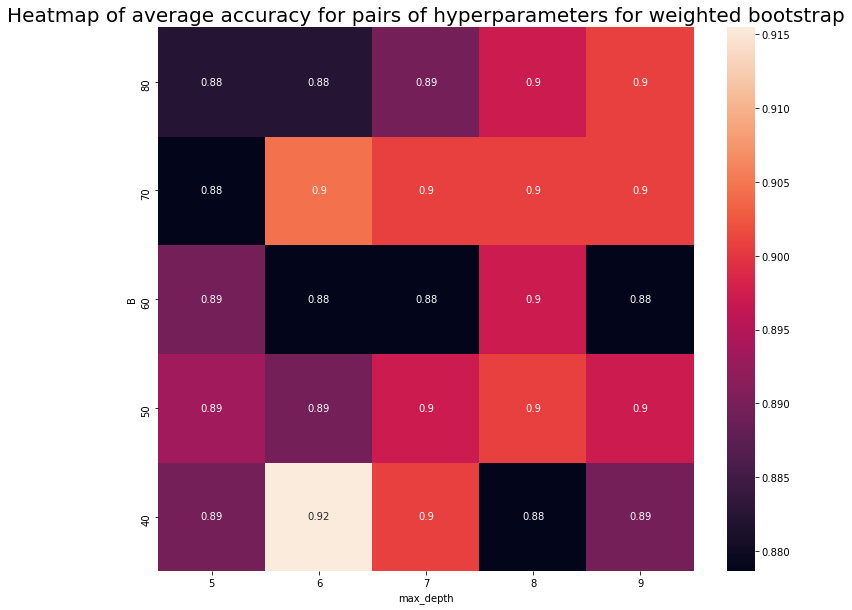

In [342]:
# Heatmap of average accuracy for pairs of hyperparameters for weighted bootstrap
df_h_w = pd.DataFrame(combination_list, columns=["B","max_depth"])
df_h_w["Average Accuracy"] = mean_val_list_balanced
df_h_w = df_h_w.pivot("B", "max_depth", "Average Accuracy")
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(df_h_w, annot=True)
plt.title("Heatmap of average accuracy for pairs of hyperparameters for weighted bootstrap", fontsize=20)
ax.invert_yaxis()

In [343]:
print("For the weighted samples, the optimal value of B is {} and optimal value of max_depth is {}".format(best_B_balanced, best_max_depth_balanced))

For the weighted samples, the optimal value of B is 40 and optimal value of max_depth is 6


We will now retrain the model on the entire weighted training dataset using the optimal B and max_depth found above.

In [344]:
# Compute accuracy, preciison and F-score
best_rf_balanced = train_rf(best_B_balanced, n_features, best_max_depth_balanced, X_d_train, y_d_train, columns_dict, training_weights_balanced)
acc_train_balanced = rf_accuracy(best_rf_balanced, X_d_train.to_numpy(), y_d_train.to_numpy(), best_B_balanced, 0.5)
acc_test_balanced = rf_accuracy(best_rf_balanced, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B_balanced, 0.5)
scores_train_balanced = rf_scores(best_rf_balanced, X_d_train.to_numpy(), y_d_train.to_numpy(), best_B_balanced, 0.5)
scores_test_balanced = rf_scores(best_rf_balanced, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B_balanced, 0.5)

In [345]:
# Table of weighted random forest scores
data_rf_w = {'Accuracy': [acc_train_balanced, acc_test_balanced], 'Precision': [scores_train_balanced[0], scores_test_balanced[0]], 'F-score':[scores_train_balanced[1], scores_test_balanced[1]]}
df_rf_w = pd.DataFrame(data_rf_w, index=['Training', 'Test'])
df_rf_w = df_rf_w.style.set_properties(**{'font-size': '14pt'})
df_rf_w = df_rf_w.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_rf_w

,Accuracy,Precision,F-score
Training,0.963370,0.840000,0.893617
Test,0.923077,0.705882,0.727273


The function `curve` computes the quality measures required to plot roc curve and precision-recall curve for each threshold. It returns the area under each curve as well.

In [346]:
def curve(rf, X_test, y_test, B, roc_threshold_list):
    """
    Arguments:
        rf: random forest model
        X_test: data of size (n, d)
        y_test: true label vector of size (n, d)
        B: number of decision trees
        roc_threshold_list: list of thresholds sorted descendingly.
  
    Returns:
        auc: area under the curve (AUC).
        tpr_l: a list of true positive rate (TPR) values for each threshold.
        fpr_l: a list of false positive rate (FPR) values for each threshold.
    """
    tpr_l, fpr_l, precision_l = [], [], []
    count_list = []
    count = 0
    
    for roc_threshold in roc_threshold_list:
        # compute quality measures required to plot roc curve and precision-recall curve
        precision, F_score, tpr, fpr = rf_scores(rf, X_test, y_test, B, roc_threshold)
        tpr_l.append(tpr)
        fpr_l.append(fpr)
        if precision is not None:
            precision_l.append(precision)
            count_list.append(count)
        count += 1
        
    # Compute AUC using Trapezoidal rule
    auc_roc = np.trapz(tpr_l, fpr_l)
    tpr_l_r = [tpr_l[i] for i in count_list]
    auc_pr = np.trapz(precision_l, tpr_l_r)
    return auc_roc, auc_pr, tpr_l, tpr_l_r, fpr_l, precision_l

In [347]:
roc_threshold_list = np.flip(np.arange(0, 1.05, 0.05))
auc_roc, auc_pr, tpr, tpr_r, fpr, precision = curve(best_rf, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B, roc_threshold_list)
auc_roc_balanced, auc_pr_balanced, tpr_balanced, tpr_r_balanced, fpr_balanced, precision_balanced = curve(best_rf_balanced, X_d_test.to_numpy(), y_d_test.to_numpy(), best_B_balanced, roc_threshold_list)

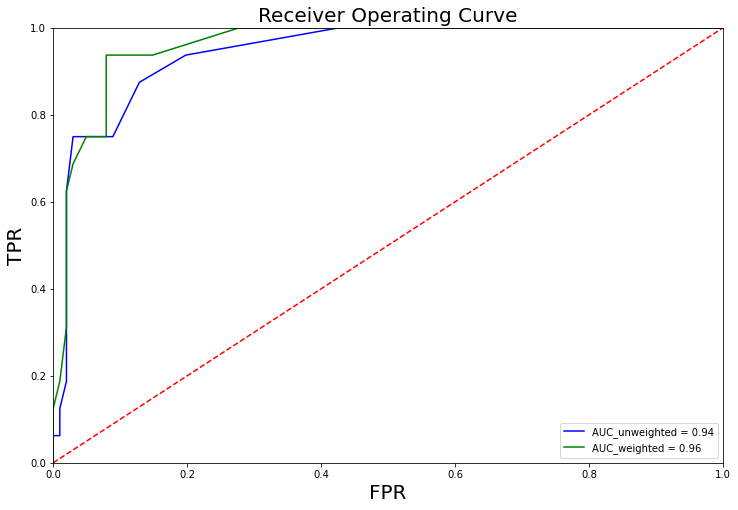

In [348]:
# ROC curve
plt.figure(figsize=(12,8))
plt.title(f"Receiver Operating Curve", size=20)
plt.plot(fpr, tpr, 'b', label = f'AUC_unweighted = {auc_roc:0.2f}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR', size=20)
plt.xlabel('FPR', size=20)
plt.plot(fpr_balanced, tpr_balanced, 'g', label = f'AUC_weighted = {auc_roc_balanced:0.2f}')
plt.legend(loc = 'lower right')
plt.show()

According to the ROC curve, the AUC for the random forest classifier with weighted bootstrap is higher than the AUC of the random forest classifier with standard bootstrap. This implies the random forest classifier with weighted bootstrap has better discriminating ability than the random forest classfier with standard bootstrap.

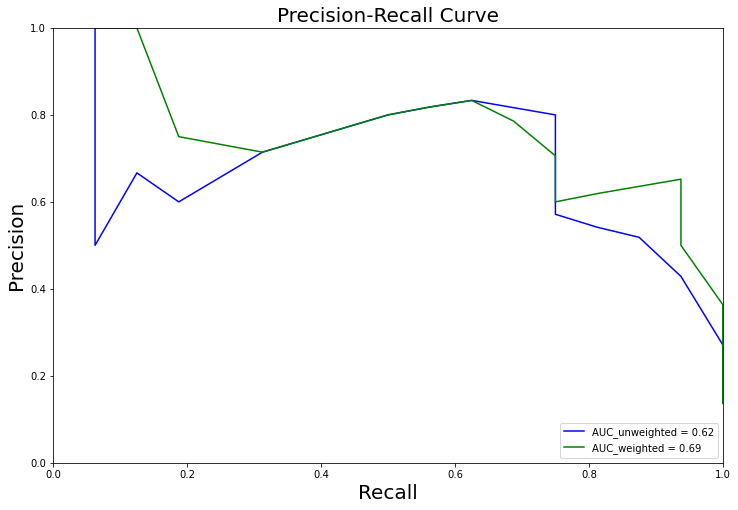

In [349]:
# Precision-Recall curve
plt.figure(figsize=(12,8))
plt.title(f"Precision-Recall Curve", size=20)
plt.plot(tpr_r, precision, 'b', label = f'AUC_unweighted = {auc_pr:0.2f}')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision', size=20)
plt.xlabel('Recall', size=20)
plt.plot(tpr_r_balanced, precision_balanced, 'g', label = f'AUC_weighted = {auc_pr_balanced:0.2f}')
plt.legend(loc = 'lower right')
plt.show()

According to the precision-recall curve, the AUC for the random forest classifier with weighted bootstrap is much higher than the AUC of the random forest classifier with standard bootstrap. This implies that the random forest classifier with weighted bootstrap is better at prediciting the minority class compared to the random forest classifier with standard bootstrap. This is also further affirmed by the fact that the F-score of the random forest classifier with weighted bootstrap is higher than the random forest classifier with standard bootstrap.

## 2.2	Support Vector Machine (SVM)

For the target variable *diabetes*, we will replace the category `No diabetes` with `-1` and the category `Diabetes` with `1`.

In [350]:
# convert categorical labels to 1: Diabetes and -1: No Diabetes
y_d_train_svm = y_d_train.copy()
y_d_train_svm = y_d_train.map({0: -1.0, 1: 1.0})
y_d_test_svm = y_d_test.copy()
y_d_test_svm = y_d_test.map({0: -1.0, 1: 1.0})

We standardise `X_d_train` and `X_d_test` using the `standardise_train` and `standardise_test` functions defined above. We also insert a column of ones in the first column of each X to include the intercept b. We assign the processed training dataset to `X_d_train_svm` and the processed test dataset to `X_d_test_svm`.

In [351]:
# standardise X and insert 1 in every row for intercept b
X_d_train_s = standardise_train(X_d_train)
X_d_train_svm = np.hstack((X_d_train_s, np.ones((len(X_d_train_s),1))))
X_d_test_s = standardise_test(X_d_train, X_d_test)
X_d_test_svm = np.hstack((X_d_test_s, np.ones((len(X_d_test_s),1))))

We aim to minimise the loss function for the soft-margin linear SVM classifier:
$$
\mathcal L (\boldsymbol w) = \frac{1}{2} \| \boldsymbol w \|^2 + \lambda \sum_{i=1}^N \max \bigg( 0, 1-y^{(i)} (x^{(i)} \cdot \boldsymbol w  + b) \bigg) \, .
$$
where $\boldsymbol w$ is the vector of weights, $\lambda$ the regularisation parameter, and $b$ the intercept which is included in our `X` as an additional column of $1$'s. <br>
The `compute_cost` function computes the cost using the formula above.

In [352]:
def compute_cost(w, X, y, regul_strength):
    n = X.shape[0]
    distances = 1 - y * (X @ w)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * np.sum(distances)

    # calculate cost
    return 0.5 * np.dot(w, w) + hinge -0.5*w[-1]**2

The function `calculate_cost_gradient` computes the gradients of the cost with respect to $\boldsymbol w$.

In [353]:
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength):
    # if only one example is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    we = w.copy() # So as not to overwrite w
    we[-1] = 0 # So as not to have b in its derivative when adding the weights in di
    
    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = we/len(y_batch) # derivative of first term
        else:
            di = we/len(y_batch) - (regul_strength * y_batch[ind] * X_batch[ind])
        dw += di

    return dw

The `sgd` function implements stochastic gradient descent to update the weights iteratively with learning rate $\alpha$ using the formula below:
$$
\boldsymbol w = \boldsymbol w - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}
$$
A stop criterion is implemented so that the algorithm stops when the change in the cost function is not significant.

In [354]:
def sgd(X, y, max_iterations, stop_criterion, learning_rate, regul_strength, print_outcome=False):
  
    # initialise zero weights
    weights = np.zeros(X.shape[1])
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
  
    # stochastic gradient descent
    indices = np.arange(len(y))

    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        X, y = X[indices], y[indices]
    
        for xi, yi in zip(X, y):
            descent = calculate_cost_gradient(weights, xi, yi, regul_strength)
            weights = weights - (learning_rate * descent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost(weights, X, y, regul_strength)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
        
            prev_cost = cost
            nth += 1
  
    return weights

The function `svm_accuracy` computes the accuracy of the predicted values of y.

In [355]:
def svm_accuracy(w, X, y):
    y_preds = np.sign(X @ w)
    return np.mean(y == y_preds)

The function `cross_val_evaluate_svm` implements T-fold cross validation and returns the accuracy for the training dataset and validation set at each training/validation split.

In [356]:
def cross_val_evaluate_svm(X, y, num_folds, regul_strength):
    folds = cross_val_split_pd(X, num_folds)

    train_scores = []
    val_scores = []
  
    for i in range(len(folds)):

        val_indices = folds[i]
        train_indices = list(set(set(X.index) - set(val_indices)))
        
        # define the training set
        X_train = X.loc[train_indices, :] 
        y_train = y[train_indices]
    
        # define the validation set
        X_val = X.loc[val_indices, :]  
        y_val = y[val_indices]
        
        # standardise X
        X_train_z = standardise_train(X_train)
        X_val_z = standardise_test(X_train, X_val)
        
        # insert 1 in every row for intercept b
        X_train_z = np.hstack((X_train_z, np.ones((len(X_train_z),1))))
        X_val_z = np.hstack((X_val_z, np.ones((len(X_val_z),1)))) 
        
        y_train = y_train.to_numpy()
        y_val = y_val.to_numpy()

        # train the model
        w = sgd(X_train_z, y_train, max_iterations=10000, stop_criterion=0.0001, learning_rate=1e-6, regul_strength=regul_strength)

        # evaluate the scores of the training and validation set
        train_score = svm_accuracy(w, X_train_z, y_train)
        val_score = svm_accuracy(w, X_val_z, y_val)
        
        # store the training scores and validation scores
        train_scores.append(train_score)
        val_scores.append(val_score)

    return train_scores, val_scores

The function `find_best_lambda` loops through the list of $\lambda$ values to find the $\lambda$ which gives the highest average accuracy for the validation set.

In [357]:
def find_best_lambda(X, y, num_folds, regul_strength_list):
    best_lambda = regul_strength_list[0]
    best_mean_val = 0
    mean_train_list =[]
    mean_val_list = []
    for regul_strength in regul_strength_list:
        # compute accuracy for each training/validation split
        train_scores, val_scores = cross_val_evaluate_svm(X, y, num_folds, regul_strength)
        
        # compute average accuracy
        mean_train = np.mean(train_scores)
        mean_val = np.mean(val_scores)
        # print("λ = {}: mean training accuracy is {}, mean validation accuracy is {}".format(regul_strength, mean_train, mean_val))
        
        # store the average MSE for training and validation set
        mean_train_list.append(mean_train)
        mean_val_list.append(mean_val)
        
        # update best λ and highest average accuracy for validation set
        if mean_val > best_mean_val:
            best_lambda = regul_strength
            best_mean_val = mean_val
    return best_lambda, best_mean_val, mean_train_list, mean_val_list

We now employ a 4-fold cross validation to tune the hardness hyperparameter $\lambda$.

In [358]:
regul_strength_list = 10 ** np.arange(-3, 7, dtype=float)
best_lambda, best_mean_val, mean_train_list, mean_val_list = find_best_lambda(X_d_train, y_d_train_svm, 4, regul_strength_list)

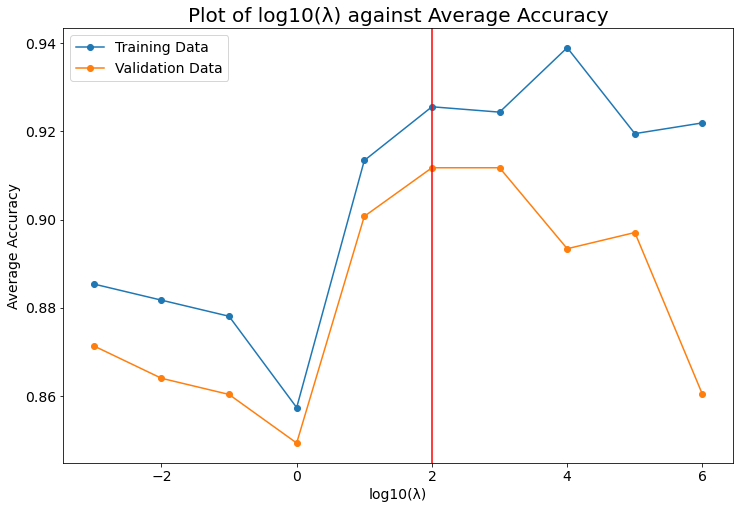

In [359]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.log10(regul_strength_list), mean_train_list, label="Training Data", marker='o')
plt.plot(np.log10(regul_strength_list), mean_val_list, label="Validation Data", marker='o')
plt.axvline(x=np.log10(best_lambda), color='r')
plt.xlabel("log10(λ)", fontsize=14)
plt.ylabel("Average Accuracy", fontsize=14)
plt.title("Plot of log10(λ) against Average Accuracy", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
ax.legend(loc="best",fontsize=14)
plt.show()

The average accuracy incrases as the hardness parameter $\lambda$ increases from $\log_{10}(\lambda)=0$ and reaches maximum at $\log_{10}(\lambda)=2$. After $\log_{10}(\lambda)=2$, the average accuracy gradually decreases. <br>
In the limit of small $\lambda$, i.e. low hardness, the model is less constrained by the regularisation and more flexible, resulting in a wider margin and more misclassifications. The variance increases and the bias decreases. If the $\lambda$ is too small, the model may become too complex, thus increasing the risk of overfitting.<br> 
In the limit of large $\lambda$, i.e. high hardness, this optimisation approcahes the hard-margin SVM, which requires the data points to be separable in d-dimensional space. This is infeasible when the separating hyperplane does not exist. The model is more constrained by the regularisation, resulting in a narrower margin and less misclassifications. The variance decreases and the bias increases. If the $\lambda$ is too large, the model may become too simple, thus increasing the risk of underfitting.

In [360]:
print("The optimal value of λ is {}".format(best_lambda))

The optimal value of λ is 100.0


We store the vectors normal to the hyperplane for each value of $\lambda$ in a list.

In [361]:
# list of vectors normal to hyperplane
w_list = [sgd(X_d_train_svm, y_d_train_svm.to_numpy(), max_iterations=10000, stop_criterion=0.001, learning_rate=1e-6, regul_strength=regul_strength) for regul_strength in regul_strength_list]

We compute the cosine angle between each pai of hyperplanes using the function `cosine_angle` and present the results on a square heatmap.

In [362]:
def cosine_angle(p, q):
    return np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))

combination_list_lambda = [p for p in product(regul_strength_list, repeat=2)]
combination_list = [p for p in product(w_list, repeat=2)]
cosine_angle_list = [cosine_angle(vector[0], vector[1]) for vector in combination_list]

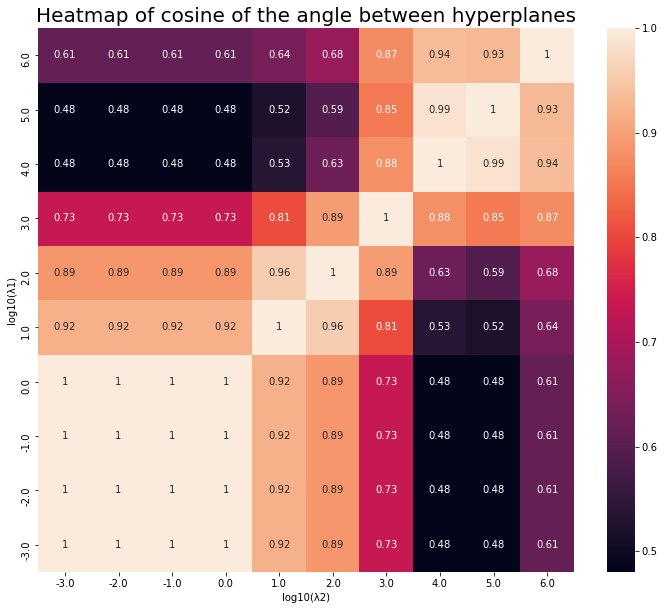

In [363]:
# plot heatmap
df_heatmap = pd.DataFrame(np.log10(combination_list_lambda), columns=["log10(λ1)","log10(λ2)"])
df_heatmap["cosine angle"] = cosine_angle_list
df_heatmap = df_heatmap.pivot("log10(λ1)", "log10(λ2)", "cosine angle")
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(df_heatmap, annot=True)
plt.title("Heatmap of cosine of the angle between hyperplanes", fontsize=20)
ax.invert_yaxis()

The function `svm_scores` computes precision and F-score of the predicted values of y.

In [364]:
def svm_scores(w, X_test, y_test):
    y_pred = np.sign(X_test @ w)
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_test)):
        if y_pred[i] == y_test[i] == 1:
            TP +=1
        elif y_pred[i] == 1 and y_test[i] == -1:
            FP +=1
        elif y_pred[i] == -1 and y_test[i] == 1:
            FN += 1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F_score = 2 * precision * recall / (precision + recall)
    return precision, F_score

We will now retrain the model on the entire training dataset using the optimal $\lambda$ found above.

In [365]:
# Compute accuracy, precision and F-score
best_w = sgd(X_d_train_svm, y_d_train_svm.to_numpy(), max_iterations=10000, stop_criterion=0.001, learning_rate=1e-5, regul_strength=best_lambda)
acc_train_svm = svm_accuracy(best_w, X_d_train_svm, y_d_train_svm.to_numpy())
acc_test_svm = svm_accuracy(best_w, X_d_test_svm, y_d_test_svm.to_numpy())
scores_train_svm = svm_scores(best_w, X_d_train_svm, y_d_train_svm.to_numpy())
scores_test_svm = svm_scores(best_w, X_d_test_svm, y_d_test_svm.to_numpy())

In [366]:
# Table of linear SVM scores
data_svm = {'Accuracy': [acc_train_svm, acc_test_svm], 'Precision': [scores_train_svm[0], scores_test_svm[0]], 'F-score':[scores_train_svm[1], scores_test_svm[1]]}
df_svm = pd.DataFrame(data_svm, index=['Training', 'Test'])
df_svm = df_svm.style.set_properties(**{'font-size': '14pt'})
df_svm = df_svm.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_svm

,Accuracy,Precision,F-score
Training,0.926740,0.833333,0.750000
Test,0.931624,0.833333,0.714286


From the table above, we observe that the precision and F-score on the test set is relatively low compared to the accuracy on the test set. This implies that the soft-margin linear SVM is sensitive to imbalanced datasets, where the high accuracy is due to the fact that the majority class only is well predicted, whereas the low precision and F-score conveys that the minority class is not well predicted. There is also slight underfitting as the accuracy on the test set is slightly higher than the accuracy and precision on the training set.

The function `kernel_matrix` computes the sigmoid kernel using the formula below:
$$k(x^{(i)},x^{(j)}|\sigma)=\tanh(\sigma(x^{(i)} \cdot x^{(j)})+1)$$

In [367]:
def kernel_matrix(X1, X2, sigma):

    n1,m1 = X1.shape
    n2,m2 = X2.shape
    kernel = np.zeros((n1,n2))

    # Here we define a sigmoid Kernel #
    for i in range(n1):
        kernel[i,:] = np.tanh(sigma * np.dot(X2, X1[i]) + 1) 
        
    return kernel

We aim to minimise the loss function for the soft-margin kernelised SVM classifier:
$$L(\mathbf{u},b) = \frac{1}{2}\mathbf{u}^{\rm{T}}\mathbf{K} \mathbf{u} + \lambda \sum_{i=1}^N  \max \Big\{0, 1-y^{(i)}(\mathbf{K}^{(i)}\mathbf{u} + b)\Big\}$$
The `compute_cost_kernel` function computes the cost using the formula above.

In [368]:
def compute_cost_kernel(u, K, y, intercept, regul_strength=10):
    
    distances = 1 - (y)*(K@u + intercept)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * np.sum(distances)

    # calculate cost
    return 0.5 * np.dot(u, K@u) + hinge

The function `calculate_cost_gradient_kernel` computes the gradients of the cost with respect to $\boldsymbol w$ and b.

In [369]:
def calculate_cost_gradient_kernel(u, K_batch, y_batch, intercept, regul_strength=10):

    # if only one example is passed
    if type(y_batch) == np.float64 or type(y_batch) == np.int32:
        y_batch = np.asarray([y_batch])
        K_batch = np.asarray([K_batch])  # gives multidimensional array
    
    distance = 1 - (y_batch * (K_batch @ u + intercept))
    dw = np.zeros(len(u))
    db = 0

    # define the gradient with the hinge loss 
    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = K_batch@u / len(y_batch)
            dj = 0
        else:
            di = K_batch@u / len(y_batch) - (regul_strength * y_batch[ind] * K_batch[ind])
            dj = - regul_strength * y_batch[ind]
        dw += di
        db += dj

    return dw, db

The function `sgd_kernel` performs stochastic gradient descent to find $\boldsymbol w$ and b.

In [370]:
def sgd_kernel(K, y, batch_size=32, max_iterations=4000, stop_criterion=0.001, learning_rate=1e-4, regul_strength=10, print_outcome=False):

    # initialise zero u and intercept
    u = np.zeros(K.shape[1])
    intercept=0
    
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        K_b, y_b = K[batch_idx], y[batch_idx]
        for ki, yi in zip(K_b, y_b):
            ascent, ascent_b = calculate_cost_gradient_kernel(u, ki, yi, intercept, regul_strength)
            u = u - (learning_rate * ascent)
            intercept = intercept - (learning_rate * ascent_b)
        
        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost_kernel(u, K, y, intercept, regul_strength)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return u, intercept
            
            prev_cost = cost
            nth += 1
    
    return u, intercept

We now train the soft margin kernelised SVM classifier by fixing $\lambda=10$ for σ=0.01, 0.1, 1, 2.

In [389]:
b_list = []
for sigma in [0.01, 0.1, 1, 2]:
    
    K_train = kernel_matrix(X_d_train_s.to_numpy(), X_d_train_s.to_numpy(), sigma)

    u, b = sgd_kernel(K_train, y_d_train_svm.to_numpy(), batch_size=128, max_iterations=10000, stop_criterion=1e-4, learning_rate=1e-7, regul_strength=10, print_outcome=False)
    
    b_list.append(b)
    # print("σ = {}: intercept b = {}".format(sigma, b))

In [390]:
# Table of value of intercept b given σ
data_b = {'b': b_list}
df_b = pd.DataFrame(data_b, index= ['σ = 0.01', 'σ = 0.1', 'σ = 1', 'σ = 2'])
df_b = df_b.style.set_properties(**{'font-size': '14pt'})
df_b = df_b.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_b

,b
σ = 0.01,-0.014134
σ = 0.1,-0.168046
σ = 1,-0.339007
σ = 2,-0.429159


2.2.5

The function `svm_k_scores` computes the accuracy, precision and F-score of the soft margin kernelised SVM classifier.

In [391]:
def svm_k_scores(u, X, y_test, sigma, intercept):
    K_test = kernel_matrix(X, X_d_train_s.to_numpy(), sigma)
        
    y_pred = np.sign(K_test@u + intercept)
    
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(y_test)):
        if y_pred[i] == y_test[i] == 1:
            TP +=1
        elif y_pred[i] == 1 and y_test[i] == -1:
            FP +=1
        elif y_pred[i] == -1 and y_test[i] == 1:
            FN += 1
        else:
            TN += 1
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    recall = TP / (TP + FN)
    if (TP + FP) == 0:
        precision = None
        F_score = None
    else:
        precision = TP / (TP + FP)
        F_score = 2 * precision * recall / (precision + recall)
    return accuracy, precision, F_score

In [392]:
a_train_list = []
p_train_list = []
f_train_list = []
a_test_list = []
p_test_list = []
f_test_list = []

for sigma in [0.01, 0.1, 1, 2]:
    
    # print('For sigma = ' + str(sigma))
    K_train = kernel_matrix(X_d_train_s.to_numpy(), X_d_train_s.to_numpy(), sigma)

    u, b = sgd_kernel(K_train, y_d_train_svm.to_numpy(), batch_size=128, max_iterations=10000, stop_criterion=1e-4, learning_rate=1e-7, regul_strength=10, print_outcome=False)
    
    scores_train_svm_k = svm_k_scores(u, X_d_train_s.to_numpy(), y_d_train_svm.to_numpy(), sigma, b)
    scores_test_svm_k = svm_k_scores(u, X_d_test_s.to_numpy(), y_d_test_svm.to_numpy(), sigma, b)
    
    a_train_list.append(scores_train_svm_k[0])
    p_train_list.append(scores_train_svm_k[1])
    f_train_list.append(scores_train_svm_k[2])
    a_test_list.append(scores_test_svm_k[0])
    p_test_list.append(scores_test_svm_k[1])
    f_test_list.append(scores_test_svm_k[2])

In [393]:
# Table of SVM scores
data_svm_all = {'Accuracy': [acc_test_svm, a_test_list[0], a_test_list[1], a_test_list[2], a_test_list[3]], 
                'Precision': [scores_test_svm[0], p_test_list[0], p_test_list[1], p_test_list[2], p_test_list[3]], 
                'F-score': [scores_test_svm[1], f_test_list[0], f_test_list[1], f_test_list[2], f_test_list[3]]}
df_svm_all = pd.DataFrame(data_svm_all, index=['Linear SVM', 'Kernelised SVM (σ = 0.01)', 'Kernelised SVM (σ = 0.1)', 'Kernelised SVM (σ = 1)', 'Kernelised SVM (σ = 2)'])
df_svm_all = df_svm_all.style.set_properties(**{'font-size': '14pt'})
df_svm_all = df_svm_all.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_svm_all

,Accuracy,Precision,F-score
Linear SVM,0.931624,0.833333,0.714286
Kernelised SVM (σ = 0.01),0.863248,nan,nan
Kernelised SVM (σ = 0.1),0.863248,nan,nan
Kernelised SVM (σ = 1),0.905983,0.666667,0.645161
Kernelised SVM (σ = 2),0.905983,0.666667,0.645161


The precision and F-score when $\sigma=0.01$ and $\sigma=0.1$ is undefined as only the majority class is predicted. This implies that SVM is sensitive to imbalance datasets for small $\sigma$.<br>
The linear SVM model outperforms all the other kernelised SVM models as it has the highest accuracy, precision and F-score. Thus, we can infer that the data points are separable by a hyperplane in d-dimensional space. The $\sigma$ and $\lambda$ hyperparameter should be optimised through cross-validation or grid search to further improve the performance of the kernelised SVM. The type of kernel can also be optimised through cross-validation or grid search.